In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mplsoccer import Pitch, VerticalPitch  
from pathlib import Path
import os
import json
import csv
from tqdm import tqdm
import logging
from dotenv import load_dotenv
from pathlib import Path
import os

load_dotenv()

DATA_ROOT = Path(os.environ["EXJOBB_DATA"])


In [3]:

DATA_ROOT = Path(os.environ.get("EXJOBB_DATA", ""))
print("DATA_ROOT:", DATA_ROOT)
print("Exists:", DATA_ROOT.exists())

# Show top-level contents
print("\nTop-level files/folders:")
for p in sorted(DATA_ROOT.iterdir())[:50]:
    print(" -", p.name)

# Try to find common football data file types
patterns = ["*.json", "*.csv", "*.parquet"]
found = []
for pat in patterns:
    found.extend(DATA_ROOT.rglob(pat))

print(f"\nFound {len(found)} data files (json/csv/parquet). Showing up to 20:")
for p in found[:20]:
    print(" -", p)

# If you have any CSV/Parquet, try to load the first one
csvs = list(DATA_ROOT.rglob("*.csv"))
parqs = list(DATA_ROOT.rglob("*.parquet"))

if csvs:
    fp = csvs[0]
    print("\nLoading first CSV:", fp)
    df = pd.read_csv(fp)
    print("Shape:", df.shape)
    print("Columns:", list(df.columns)[:30])
    print(df.head(3))
elif parqs:
    fp = parqs[0]
    print("\nLoading first Parquet:", fp)
    df = pd.read_parquet(fp)
    print("Shape:", df.shape)
    print("Columns:", list(df.columns)[:30])
    print(df.head(3))
else:
    print("\nNo CSV/Parquet found to test-load. If your data is JSON only, tell me the folder layout.")


DATA_ROOT: /Volumes/Samsung USB/EX-Jobb/data
Exists: True

Top-level files/folders:
 - J1_league
 - Rådata Playmaker.zip
 - allsvenskan
 - open-data-master
 - open-data-master.zip
 - premier_league
 - wyscout-soccer-match-event-dataset-main
 - wyscout-soccer-match-event-dataset-main.zip

Found 11854 data files (json/csv/parquet). Showing up to 20:
 - /Volumes/Samsung USB/EX-Jobb/data/J1_league/sb_matches.json
 - /Volumes/Samsung USB/EX-Jobb/data/J1_league/hudl_physical.json
 - /Volumes/Samsung USB/EX-Jobb/data/J1_league/Statsbomb_J1_League.json
 - /Volumes/Samsung USB/EX-Jobb/data/open-data-master/data/competitions.json
 - /Volumes/Samsung USB/EX-Jobb/data/open-data-master/data/events/15946.json
 - /Volumes/Samsung USB/EX-Jobb/data/open-data-master/data/events/15956.json
 - /Volumes/Samsung USB/EX-Jobb/data/open-data-master/data/events/15973.json
 - /Volumes/Samsung USB/EX-Jobb/data/open-data-master/data/events/15978.json
 - /Volumes/Samsung USB/EX-Jobb/data/open-data-master/data/even

In [4]:
# Example: Check for StatsBomb open-data structure

sb_root = DATA_ROOT / "open-data-master" / "data"
matches_dir = sb_root / "matches"
events_dir = sb_root / "events"

print("StatsBomb root:", sb_root)
print("matches_dir exists:", matches_dir.exists())
print("events_dir exists:", events_dir.exists())

# Load competitions
comps = pd.read_json(sb_root / "competitions.json")
print("\nCompetitions:", comps.shape)
print(comps[["competition_id", "season_id", "competition_name", "season_name"]].head(10))

# Show match files available
match_files = sorted(matches_dir.rglob("*.json"))
print(f"\nMatch files found: {len(match_files)}")
print("First 10:")
for p in match_files[:10]:
    print(" -", p.relative_to(sb_root))


StatsBomb root: /Volumes/Samsung USB/EX-Jobb/data/open-data-master/data
matches_dir exists: True
events_dir exists: True

Competitions: (75, 12)
   competition_id  season_id        competition_name season_name
0               9        281           1. Bundesliga   2023/2024
1               9         27           1. Bundesliga   2015/2016
2            1267        107  African Cup of Nations        2023
3              16          4        Champions League   2018/2019
4              16          1        Champions League   2017/2018
5              16          2        Champions League   2016/2017
6              16         27        Champions League   2015/2016
7              16         26        Champions League   2014/2015
8              16         25        Champions League   2013/2014
9              16         24        Champions League   2012/2013

Match files found: 75
First 10:
 - matches/11/1.json
 - matches/11/2.json
 - matches/11/21.json
 - matches/11/22.json
 - matches/11/23.json

In [5]:
threesixty_dir = sb_root / "three-sixty"
three_files = sorted(threesixty_dir.glob("*.json"))
three_match_ids = {int(p.stem) for p in three_files}

print("three-sixty dir exists:", threesixty_dir.exists())
print("360 match files:", len(three_files))
print("Example match_ids:", list(sorted(three_match_ids))[:10])

three-sixty dir exists: True
360 match files: 326
Example match_ids: [3788741, 3788742, 3788743, 3788744, 3788745, 3788746, 3788747, 3788748, 3788749, 3788750]


In [6]:
rows = []
for mf in sorted((sb_root / "matches").rglob("*.json")):
    comp_id = int(mf.parent.name)
    season_id = int(mf.stem)
    data = json.loads(mf.read_text())
    for m in data:
        rows.append({
            "competition_id": comp_id,
            "season_id": season_id,
            "match_id": m["match_id"],
            "match_date": m.get("match_date"),
            "home_team": m["home_team"]["home_team_name"],
            "away_team": m["away_team"]["away_team_name"],
        })

matches_all = pd.DataFrame(rows)

matches_360 = matches_all[matches_all["match_id"].isin(three_match_ids)].copy()

# join competition names
matches_360 = matches_360.merge(
    comps[["competition_id","season_id","competition_name","season_name"]],
    on=["competition_id","season_id"],
    how="left"
)

print("Matches with 360:", len(matches_360))
matches_360.sort_values(["competition_name","season_name","match_date"]).head(20)

Matches with 360: 326


,competition_id,season_id,match_id,match_date,home_team,away_team,competition_name,season_name
325,9,281,3895052,2023-08-19,Bayer Leverkusen,RB Leipzig,1. Bundesliga,2023/2024
324,9,281,3895060,2023-08-26,Borussia Mönchengladbach,Bayer Leverkusen,1. Bundesliga,2023/2024
323,9,281,3895067,2023-09-02,Bayer Leverkusen,Darmstadt 98,1. Bundesliga,2023/2024
306,9,281,3895074,2023-09-15,Bayern Munich,Bayer Leverkusen,1. Bundesliga,2023/2024
308,9,281,3895086,2023-09-24,Bayer Leverkusen,FC Heidenheim,1. Bundesliga,2023/2024
322,9,281,3895095,2023-09-30,FSV Mainz 05,Bayer Leverkusen,1. Bundesliga,2023/2024
305,9,281,3895107,2023-10-08,Bayer Leverkusen,FC Köln,1. Bundesliga,2023/2024
321,9,281,3895113,2023-10-21,Wolfsburg,Bayer Leverkusen,1. Bundesliga,2023/2024
304,9,281,3895121,2023-10-29,Bayer Leverkusen,Freiburg,1. Bundesliga,2023/2024
303,9,281,3895134,2023-11-04,Hoffenheim,Bayer Leverkusen,1. Bundesliga,2023/2024


In [7]:
coverage = (matches_360.groupby(["competition_name","season_name"])
            .size()
            .reset_index(name="n_matches_360")
            .sort_values("n_matches_360", ascending=False))
coverage.head(30)


,competition_name,season_name,n_matches_360
1,FIFA World Cup,2022,64
6,Women's World Cup,2023,64
2,UEFA Euro,2020,51
3,UEFA Euro,2024,51
0,1. Bundesliga,2023/2024,34
4,UEFA Women's Euro,2022,31
5,UEFA Women's Euro,2025,31


In [8]:
import pandas as pd

mid = matches_360.iloc[0]["match_id"]

events = pd.read_json(sb_root / "events" / f"{mid}.json")
three  = pd.read_json(sb_root / "three-sixty" / f"{mid}.json")

print("events rows:", len(events), "three-sixty rows:", len(three))

# pick a 360 record and find its corresponding event
r = three.iloc[0]
ev = events[events["id"] == r["event_uuid"]].iloc[0]

print("Event type:", ev["type"]["name"])
print("Event time:", ev.get("timestamp"), "minute:", ev.get("minute"), "second:", ev.get("second"))
print("Freeze frame players:", len(r["freeze_frame"]) if isinstance(r["freeze_frame"], list) else None)
print("Visible area points:", len(r["visible_area"]) if isinstance(r["visible_area"], list) else None)


events rows: 3211 three-sixty rows: 2637
Event type: Pass
Event time: 2026-01-28 00:00:00.521000 minute: 0 second: 0
Freeze frame players: 19
Visible area points: 10


In [18]:

def visible_area_to_xy(vis):
    """
    Accepts StatsBomb visible_area in either format:
      - flat:   [x1, y1, x2, y2, ...]
      - nested: [[x1, y1], [x2, y2], ...]
    Returns Nx2 float array or None.
    """
    if vis is None:
        return None

    arr = np.asarray(vis, dtype=float)

    # nested case: shape (N, 2)
    if arr.ndim == 2 and arr.shape[1] == 2:
        if arr.shape[0] >= 3:
            return arr
        return None

    # flat case: shape (2N,)
    if arr.ndim == 1:
        if arr.size >= 6 and arr.size % 2 == 0:
            return arr.reshape(-1, 2)
        return None

    return None

def plot_freeze_frame(sb_root, match_id: int, event_uuid: str, *, figsize=(10, 7)):
    """
    sb_root: Path to .../open-data-master/data
    match_id: StatsBomb match_id (int)
    event_uuid: the UUID from events['id'] (string)
    """
    three_path = sb_root / "three-sixty" / f"{match_id}.json"
    events_path = sb_root / "events" / f"{match_id}.json"

    three = json.loads(three_path.read_text())
    events = json.loads(events_path.read_text())

    # --- find the 360 record for this event
    rec = next((r for r in three if r.get("event_uuid") == event_uuid), None)
    if rec is None:
        raise ValueError("No three-sixty record found for that event_uuid (no 360 for this event).")
    vis = rec.get("visible_area")
    print(type(vis), "len:", len(vis) if vis is not None else None)
    print("first 3 items:", vis[:3] if isinstance(vis, list) else vis)

    arr = np.asarray(vis, dtype=object)
    print("np shape:", arr.shape, "ndim:", arr.ndim)
    bad = [(i, type(v), v) for i, v in enumerate(vis) if not isinstance(v, (int, float))]
    print("bad entries:", bad[:10])

    # --- find the event (optional, just for a title)
    ev = next((e for e in events if e.get("id") == event_uuid), None)

    pitch = Pitch(pitch_type="statsbomb")  # StatsBomb coordinate system 120x80
    fig, ax = pitch.draw(figsize=figsize)

        # --- visible area polygon
    vis = rec.get("visible_area")
    if isinstance(vis, list) and len(vis) >= 6 and len(vis) % 2 == 0:
        vis_xy = np.array(vis, dtype=float).reshape(-1, 2)
        pitch.polygon([vis_xy], ax=ax, alpha=0.15)  # wrap in list



    # --- players
    ff = rec.get("freeze_frame", [])
    if not isinstance(ff, list):
        ff = []

    locs = []
    teammate = []
    actor = []
    keeper = []

    for p in ff:
        if "location" not in p or p["location"] is None:
            continue
        x, y = p["location"]
        locs.append((x, y))
        teammate.append(bool(p.get("teammate", False)))
        actor.append(bool(p.get("actor", False)))
        keeper.append(bool(p.get("keeper", False)))

    if locs:
        locs = np.array(locs)

        # Split into teammate / opponent for different markers
        tm = np.array(teammate, dtype=bool)
        op = ~tm

        # Basic dots
        if tm.any():
            pitch.scatter(locs[tm, 0], locs[tm, 1], ax=ax, s=120, marker="o", edgecolors="black", linewidth=1)
        if op.any():
            pitch.scatter(locs[op, 0], locs[op, 1], ax=ax, s=120, marker="s", edgecolors="black", linewidth=1)

        # Highlight actor (ring)
        ac = np.array(actor, dtype=bool)
        if ac.any():
            pitch.scatter(locs[ac, 0], locs[ac, 1], ax=ax, s=350, facecolors="none", edgecolors="black", linewidth=2)

        # Highlight keeper (bigger marker)
        kp = np.array(keeper, dtype=bool)
        if kp.any():
            pitch.scatter(locs[kp, 0], locs[kp, 1], ax=ax, s=220, marker="^", edgecolors="black", linewidth=1)

    # Title
    if ev is not None:
        ev_type = ev.get("type", {}).get("name", "Event")
        minute = ev.get("minute")
        second = ev.get("second")
        fig.suptitle(f"{ev_type} @ {minute}:{second:02d}  | match {match_id}", y=0.98)

    plt.show()
    return fig, ax

<class 'list'> len: 12
first 3 items: [97.0528676292184, 79.3833424200479, 68.1887917730604]
np shape: (12,) ndim: 1
bad entries: []


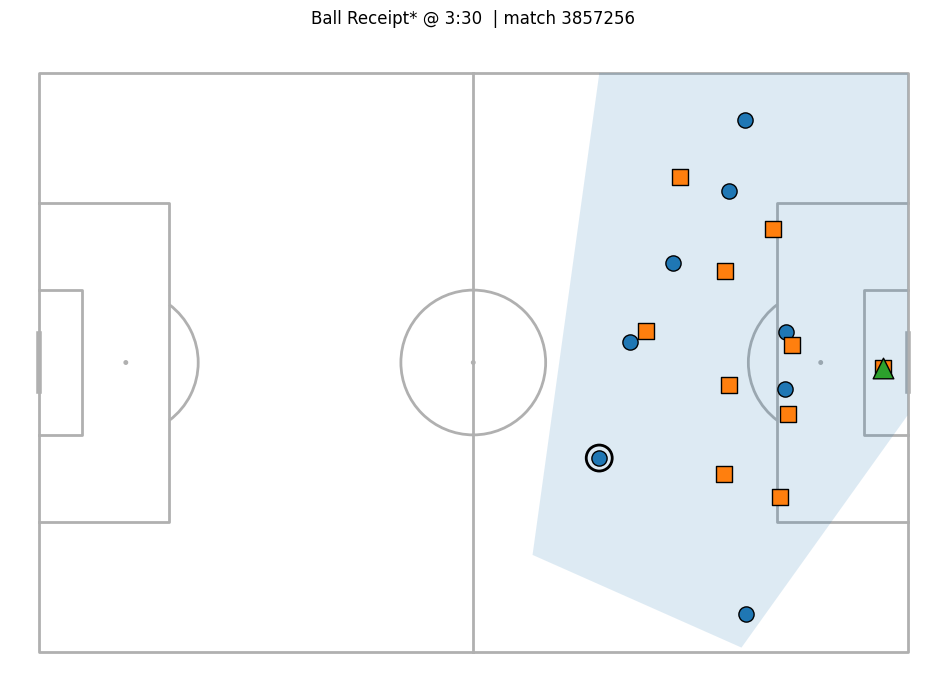

(<Figure size 1000x700 with 1 Axes>, <Axes: >)

In [37]:
match_id = matches_360.iloc[0]["match_id"]
three = json.loads((sb_root / "three-sixty" / f"{match_id}.json").read_text())
event_uuid = three[136]["event_uuid"]

plot_freeze_frame(sb_root, match_id, event_uuid)

In [11]:
mid = match_id

events = pd.read_json(sb_root / "events" / f"{mid}.json")
three  = pd.read_json(sb_root / "three-sixty" / f"{mid}.json")

events_with_360 = set(three["event_uuid"])
events["has_360"] = events["id"].isin(events_with_360)

print("Coverage:", events["has_360"].mean())

# Which event types miss 360 most?
miss_by_type = (events[~events["has_360"]]
                .assign(type_name=events[~events["has_360"]]["type"].apply(lambda d: d["name"]))
                .groupby("type_name")
                .size()
                .sort_values(ascending=False))
print(miss_by_type.head(15))

Coverage: 0.8212394892556836
type_name
Pass                 221
Ball Receipt*        126
Carry                 69
Pressure              29
Duel                  20
Goal Keeper           16
Ball Recovery         11
Injury Stoppage       10
Block                  9
Substitution           9
Dispossessed           9
Dribble                5
Bad Behaviour          4
Referee Ball-Drop      4
Half End               4
dtype: int64
